# Metadata

```yaml
Course:    DS 5001 
Module:    12 Lab
Topic:     Classification with Perceptron
Author:    R.C. Alvarado
Date:      16 April 2023 (revised)
```

# Overview 

1. $X \rightarrow x$
2. $x \dot W = y^\prime$
3. $f(y^\prime) = y$ 

# Set Up

## Config

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
data_prefix = 'winereviews'
data_path = f"{data_home}/{data_prefix}/{data_prefix}"

## Import

In [3]:
import pandas as pd
import numpy as np
import plotly_express as px
from sklearn.linear_model import LogisticRegression

# Preparation

## Get Data

In [4]:
X_test = pd.read_pickle(f"{data_path}-X_test.csv.pickle").sort_index()
X_train = pd.read_pickle(f"{data_path}-X_train.csv.pickle").sort_index()
y_test = pd.read_pickle(f"{data_path}-y_test.csv.pickle").sort_index()
y_train = pd.read_pickle(f"{data_path}-y_train.csv.pickle").sort_index()

In [5]:
DOC = pd.read_csv(f"{data_path}-DOC_UNSPLIT.csv").set_index('doc_id')

# Training

In [6]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

# Testing

In [7]:
# y_hat = pd.DataFrame(clf.predict(X_test), index=X_test.index)

In [8]:
LOGPROB = pd.DataFrame(clf.predict_log_proba(X_test), index=X_test.index)
LOGPROB.columns = clf.classes_

In [9]:
y_hat = LOGPROB.idxmax(1)

# Evaluation

In [10]:
clf.score(X_test, y_test)

0.822

In [11]:
# RESULT

NameError: name 'RESULT' is not defined

In [12]:
RESULT = pd.concat([y_test, y_hat], axis=1)
RESULT.columns = ['doc_label', 'prediction']

In [13]:
RESULT['result'] = RESULT.doc_label == RESULT.prediction

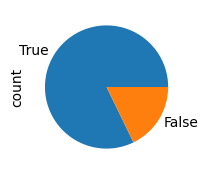

In [14]:
RESULT.value_counts('result').plot.pie(figsize=(2,2));

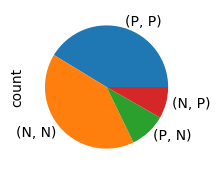

In [15]:
RESULT.value_counts(['prediction','doc_label']).plot.pie(figsize=(2,2));

In [16]:
X = RESULT.join(LOGPROB).join(DOC[['doc_content','points','doc_len']], how='inner').reset_index()

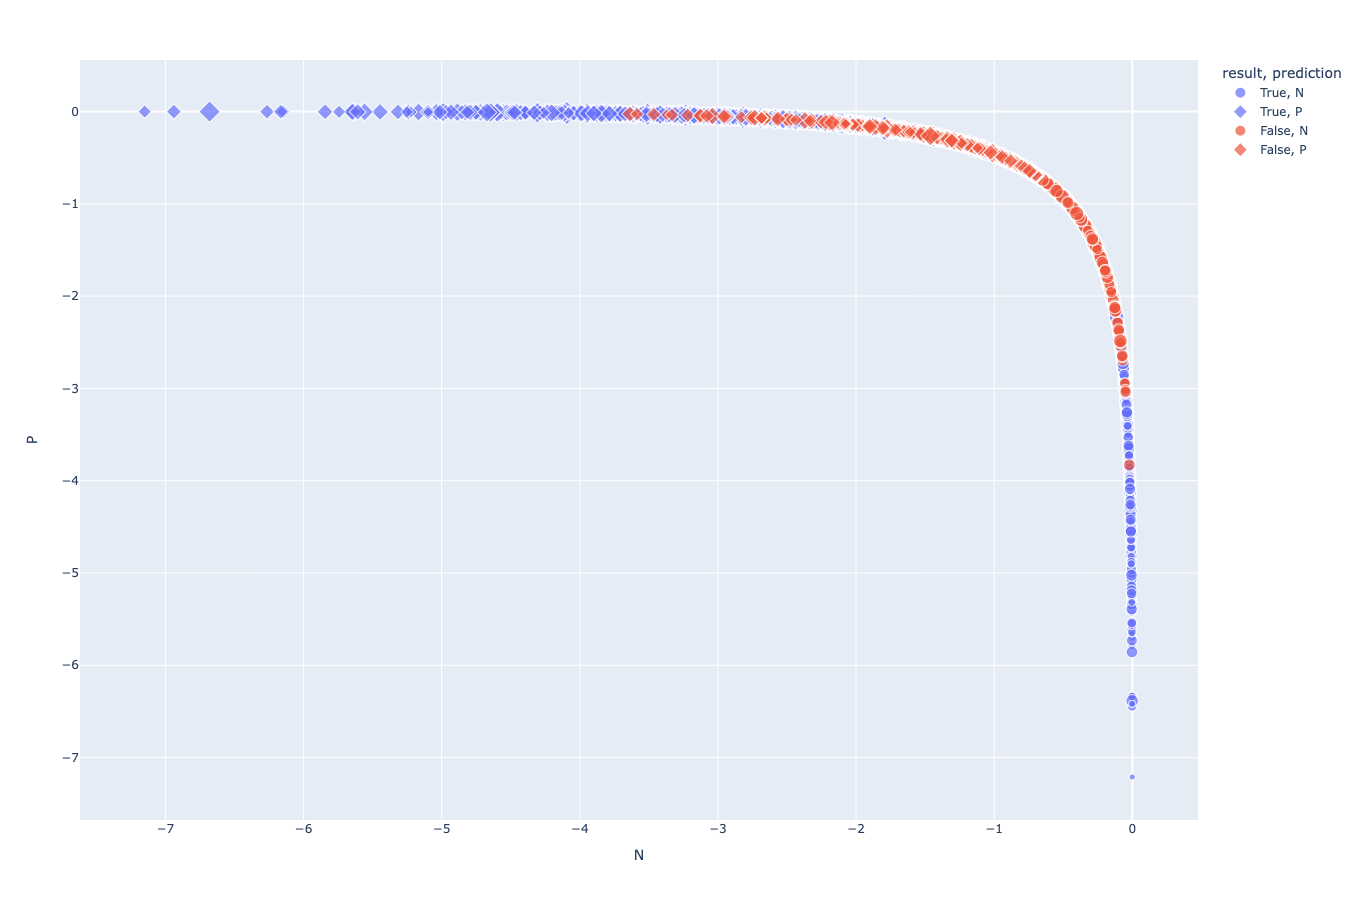

In [17]:
px.scatter(X, 'N', 'P', 
        color='result', symbol='prediction', size='doc_len',
          height=900, width=1000)

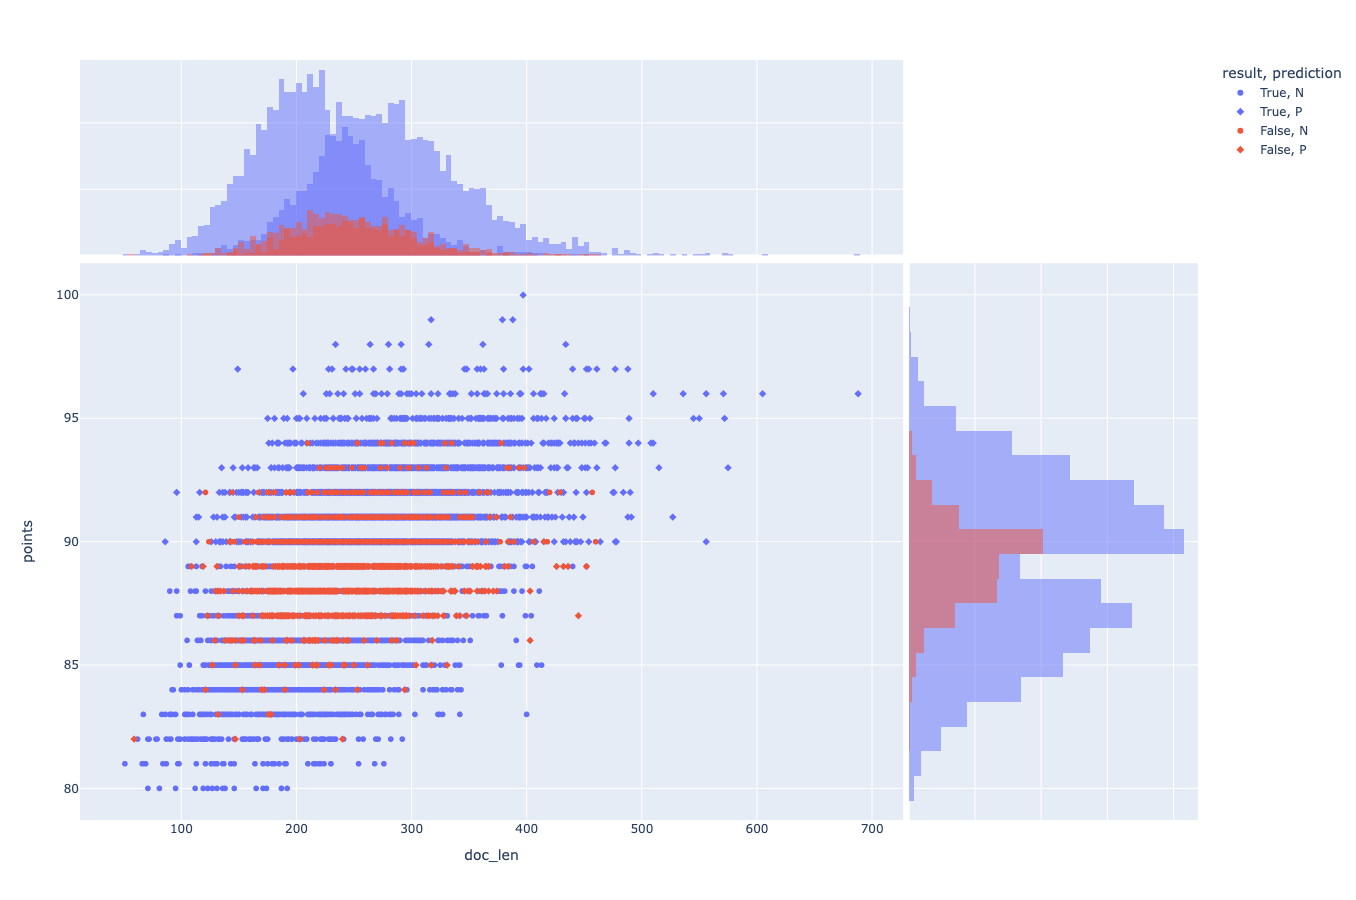

In [18]:
px.scatter(RESULT.join(DOC[['doc_content','points','doc_len']], how='inner').reset_index(), 
           'doc_len', 'points', 
           color='result',
           symbol='prediction',
           height=900, width=1000, marginal_x='histogram', marginal_y='histogram')

In [19]:
CM = RESULT.value_counts(['prediction','doc_label']).unstack()

In [20]:
CM

doc_label      N     P
prediction            
N           3271   660
P            764  3305

In [21]:
def get_results(CM, model_id):
    
    R = pd.DataFrame(index=[model_id])
    R.index.name = 'model_id'
    
    # COUNTS
    R['TN'] = CM.iloc[0,0]   # correct rejections
    R['FN'] = CM.iloc[0,1]   # Type II errors or misses
    R['TP'] = CM.iloc[1,1]   # hits
    R['FP'] = CM.iloc[1,0]   # Type I errors or false alarms
    R['T'] = R.TP + R.TN     # All True
    R['F'] = R.FP + R.FN     # All False
    R['ALL'] = R['T'] + R.F  # All
    
    assert R.ALL.values[0] == CM.sum().sum()
    
    # RATIOS
    R['ACC'] = R['T'] / R.ALL                        # (Simple) Accuracy
    R['TPR'] = R.TP / (R.TP + R.FN)                  # Recall or Sensitivity
    R['TNR'] = R.TN / (R.TN + R.FP)                  # Specificity
    R['PPV'] = R.TP / (R.TP + R.FP)                  # Precision or Positive predictive value 
    R['BA'] = (R.TNR + R.TPR) / 2                    # Balanced Accuracy
    R['F1'] = (2 *  R.TP) / (2 * R.TP + R.FP + R.FN) # F-score where F = 1

    return R

In [22]:
R = get_results(CM, 'logreg')

In [23]:
R.T.style.format(precision=3)

# Extract Sentiment

We treat weight as valence.

In [24]:
SALEX = pd.DataFrame(dict(valence=clf.coef_[0]), index=clf.feature_names_in_)
SALEX.index.name = 'term_str'
SALEX = SALEX.sort_values('valence')
SALEX['polarity'] = np.sign(SALEX['valence'])

In [25]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
scaler = MinMaxScaler(feature_range=(-1, 1))
SALEX['normalized'] = scaler.fit_transform(SALEX[['valence']])

In [27]:
SALEX.sort_values('valence', ascending=False).head(20)

valence  polarity  normalized
term_str                                   
2020         6.142065       1.0    1.000000
2022         5.681120       1.0    0.923412
complex      5.390267       1.0    0.875086
2021         4.731279       1.0    0.765592
impressive   4.728504       1.0    0.765131
beautiful    4.637415       1.0    0.749996
2025         4.600886       1.0    0.743926
long         4.365656       1.0    0.704842
delicious    4.364954       1.0    0.704725
elegant      4.176262       1.0    0.673373
vineyard     4.162940       1.0    0.671160
beautifully  4.108028       1.0    0.662036
lovely       3.861575       1.0    0.621087
years        3.829114       1.0    0.615693
2024         3.812948       1.0    0.613007
velvety      3.613285       1.0    0.579832
2023         3.484205       1.0    0.558385
great        3.482924       1.0    0.558172
2018         3.467548       1.0    0.555618
powerful     3.435264       1.0    0.550253

In [28]:
SALEX.sort_values('valence', ascending=True).head(20)

valence  polarity  normalized
term_str                                       
simple          -5.894941      -1.0   -1.000000
straightforward -3.947883      -1.0   -0.676488
easy            -3.771609      -1.0   -0.647199
lacks           -3.702925      -1.0   -0.635787
flavors         -3.481245      -1.0   -0.598954
soft            -3.274257      -1.0   -0.564562
rustic          -3.241550      -1.0   -0.559128
short           -3.130705      -1.0   -0.540710
medium          -3.053026      -1.0   -0.527804
somewhat        -3.050045      -1.0   -0.527308
bit             -2.791881      -1.0   -0.484413
easygoing       -2.776301      -1.0   -0.481825
everyday        -2.767002      -1.0   -0.480280
little          -2.713962      -1.0   -0.471467
lean            -2.585994      -1.0   -0.450204
light           -2.578277      -1.0   -0.448922
aromas          -2.576026      -1.0   -0.448548
good            -2.575896      -1.0   -0.448526
bitter          -2.532961      -1.0   -0.441393
drinking        -2.391529      -1.0   -0.417893

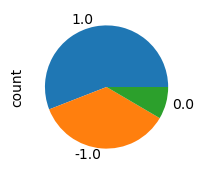

In [29]:
SALEX.polarity.value_counts().plot.pie(figsize=(2,2));

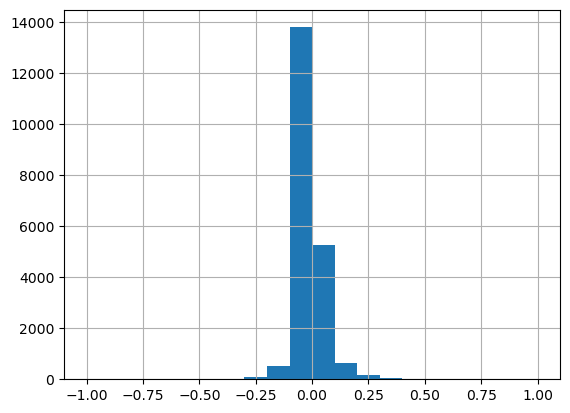

In [30]:
SALEX.normalized.hist(bins=20);

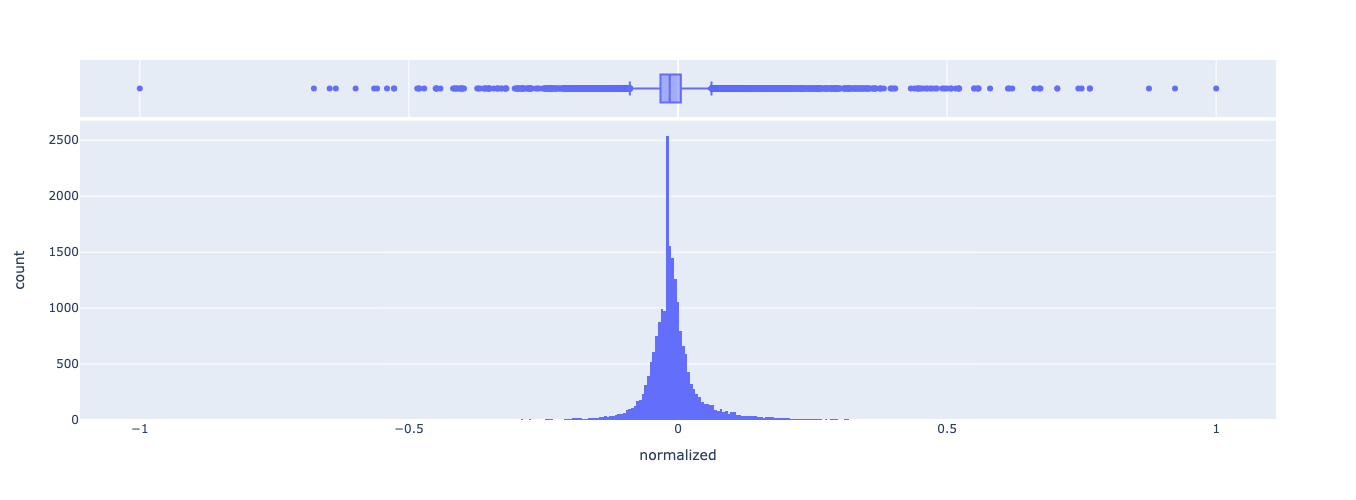

In [31]:
px.histogram(SALEX.reset_index(), x='normalized', hover_name='term_str', marginal='box', width=700, height=500)

In [32]:
(SALEX.normalized < -.3).sum()

55

In [33]:
(SALEX.normalized > .05).sum()

1865

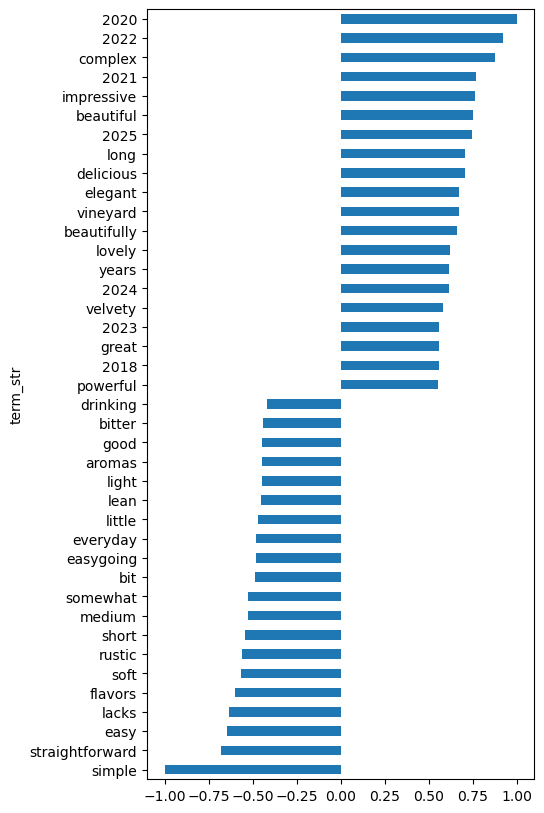

In [34]:
pd.concat([SALEX.normalized.head(20),SALEX.normalized.tail(20)]).plot.barh(figsize=(5,10));

# Save

In [35]:
SALEX.to_csv(f'{data_path}-LOGREG_SALEX.csv')
R.to_csv(f"{data_path}-LOGREG_RESULT.csv", index=True)